In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import scipy, os
from sklearn.metrics import confusion_matrix
import seaborn as sns

import sys
sys.path.append('../../Share/')
sys.path.append('../../Share/Manual_processing/')
import baseline, config, Model, utils, Same_with_MATLAB, Feature_info

import warnings
warnings.filterwarnings('ignore')


def restore_labels(mat, labels_windowed):

    original_length = mat['Data_ADC'].shape[1]
    win_size = 600 #Original
    win_step = 120
    valid_length = original_length - 2 * 60

    label_full = np.zeros(original_length, dtype=labels_windowed.dtype) # 복원될 시계열 레이블 (원본 길이)

    # 슬라이딩 윈도우 인덱스 따라 레이블 채워넣기
    for i, label in enumerate(labels_windowed):
        start = 60 + i * win_step
        end = start + win_size
        if end <= original_length - 60:
            label_full[start:end] = label

    return label_full


def filtering_zero(X, y, erase_label):
    # 1. erase_label 제거
    keep_indices = y != erase_label
    X = X[keep_indices]
    y = y[keep_indices]

    # 2. erase_label보다 큰 값은 1씩 감소
    y = np.where(y > erase_label, y - 1, y)

    return X, y

def vis_graph(history):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.show()

def heatmap_confusion_matrix(X_test, y_test, model):
    # Predict class labels on the test set
    y_pred_probs = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)  # convert softmax probs to predicted class
    y_true = y_test
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(np.max(y_test)+1), yticklabels=range(np.max(y_test)+1))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


from collections import Counter

def balance_data(X, y):
    # Count samples per class
    class_counts = Counter(y)
    min_count = min(class_counts.values())  # target: balance all to minority count

    indices_list = []

    for label in sorted(class_counts.keys()):
        label_indices = np.where(y == label)[0]
        selected_indices = np.random.choice(label_indices, size=min_count, replace=False)
        indices_list.extend(selected_indices)

    # Shuffle all selected indices
    balanced_indices = np.random.permutation(indices_list)

    # Subset the data
    X_balanced = X[balanced_indices]
    y_balanced = y[balanced_indices]

    return X_balanced, y_balanced

In [11]:
def return_X_y(path, balance):
    fs, lower_cutoff, upper_cutoff = Feature_info.fs, Feature_info.lower_cutoff, Feature_info.upper_cutoff
    # fs, lower_cutoff, upper_cutoff = Feature_info.fs, 1, 300
    filter_b, filter_a = Same_with_MATLAB.cheby2(4, 30, [lower_cutoff / (fs/2), upper_cutoff / (fs/2)], btype='bandpass')

    data_per_class_files = os.listdir(path)
    X, y = [], []

    for cls in data_per_class_files:
        input_path = path+cls+'/'
        files = os.listdir(input_path)
        mat = scipy.io.loadmat(input_path+files[0])
        label = mat['Data_Cls'].reshape(-1)  # shape: (1, 1729)

        feat_mean = np.tile(Feature_info.feat_mean_lst, (4, 1))
        feat_std = np.tile(Feature_info.feat_std_lst, (4, 1))

        mapped_label = np.where(label == 0, 0, int(cls))
        restored_label = restore_labels(mat, mapped_label)

        #print(mat['Data_ADC'].shape, mat['Data_Cls'].shape, restored_label.shape)
        extractor = Same_with_MATLAB.EMGFeatureExtractor(feat_mean, feat_std, filter_b, filter_a, Norm_bool=True, num_feature_set=14) #I tried 23, but not so good
        extractor.buffer = mat['Data_ADC']
        #1000, 50 = winsize and winstep
        features, labels = extractor.extract_features_with_labels(win_size=1000, win_step=50, feat_exclude=25, filtering=False, restored_label=restored_label)

        features = np.transpose(features, (2, 0, 1))  # shape: (1729, 4, 14)
        X.append(features)
        y.append(labels)
        #print(features.shape, labels.shape)

    X_train = np.concatenate(X, axis=0)
    y_train = np.concatenate(y, axis=0)
    X_train = X_train[:, :, :, np.newaxis]
    #print(pd.Series(y_train).value_counts())
    #print(X_train.shape, y_train.shape)

    if balance:
        X_train, y_train = balance_data(X_train, y_train)

    return X_train, y_train


def train_model_feature_wise(X_train, y_train, X_test, y_test):
    X_train, y_train = filtering_zero(X_train, y_train, erase_label=0)
    X_test, y_test = filtering_zero(X_test, y_test, erase_label=0)
    ACC_lst = []

    for feature_idx in [2, 10]:
        One_X_train = X_train[:, :, feature_idx, :]
        One_X_test = X_test[:, :, feature_idx, :]

        model = Model.Original_model_1DCNN(One_X_train.shape[1:], num_class=np.max(y_train)+1)

        history, model = Model.Train_model(
            model, One_X_train, y_train, One_X_test, y_test,
            set_epoch=200, set_batch_size=256, Model_name='V0',
            set_verbose=False, save_model_set=False
        )
        ACC_lst.append(np.max(history.history['val_accuracy']))
        #vis_graph(history)
        #print("\n\n")
        #heatmap_confusion_matrix(One_X_test, y_test, model)

def train_model(X_train, y_train, X_test, y_test, heatmap_bool=False):
    X_train, y_train = filtering_zero(X_train, y_train, erase_label=0)
    X_test, y_test = filtering_zero(X_test, y_test, erase_label=0)

    model = Model.Original_model(X_train.shape[1:], num_class=np.max(y_train)+1)

    history, model = Model.Train_model(
        model, X_train, y_train, X_test, y_test,
        set_epoch=100, set_batch_size=256, Model_name='V0',
        set_verbose=False, save_model_set=False
    )
    vis_graph(history)
    if heatmap_bool:
        heatmap_confusion_matrix(X_test, y_test, model)

def run(subject, modality):
    if modality == 'EMG': bluetooth_id = 'E8DD80E550BB'
    elif modality == 'ENG': bluetooth_id = 'E9AD0E7DCC2B'
    else:
        print("Modality should be EMG or ENG")
        return

    X_train, y_train = return_X_y(path = base_path+f'{subject}/{modality}_v1/{bluetooth_id}/raw/', balance=True)
    X_test, y_test = return_X_y(path = base_path+f'{subject}/{modality}_v2/{bluetooth_id}/raw/', balance=True)
    train_model(X_train, y_train, X_test, y_test, heatmap_bool=False)

    X_train, y_train = return_X_y(path = base_path+f'{subject}/{modality}_v2/{bluetooth_id}/raw/', balance=True)
    X_test, y_test = return_X_y(path = base_path+f'{subject}/{modality}_v1/{bluetooth_id}/raw/', balance=True)
    train_model(X_train, y_train, X_test, y_test, heatmap_bool=False)


def get_data(subject, modality):
    if modality == 'EMG': bluetooth_id = 'E8DD80E550BB'
    elif modality == 'ENG': bluetooth_id = 'E9AD0E7DCC2B'
    else:
        print("Modality should be EMG or ENG")
        return

    X_session1, y_session1 = return_X_y(path = base_path+f'{subject}/{modality}_v1/{bluetooth_id}/raw/', balance=True)
    X_session2, y_session2 = return_X_y(path = base_path+f'{subject}/{modality}_v2/{bluetooth_id}/raw/', balance=True)

    return X_session1, y_session1, X_session2, y_session2

In [4]:
base_path = 'C:/Users/hml76/PycharmProjects/MindForce/data/EMG_ENG/'

Start Training (total epochs: 100)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 21.01%
Maximum validation accuracy : 17.23%


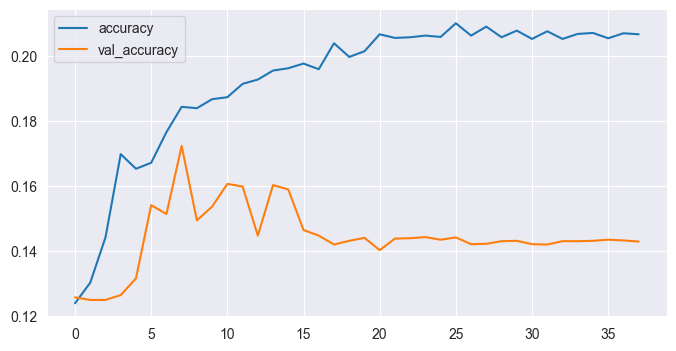

Start Training (total epochs: 100)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 14.3%
Maximum validation accuracy : 15.98%


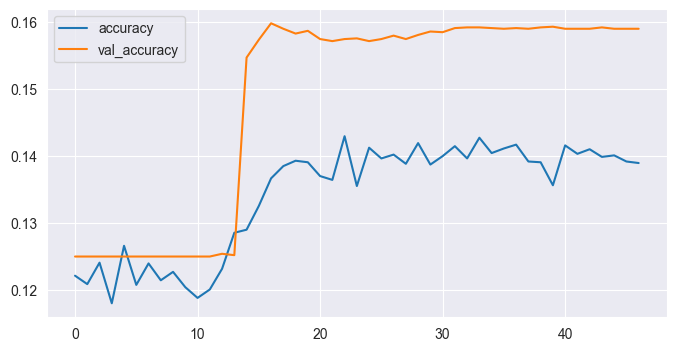

In [12]:
X_emg1, y_emg1, X_emg2, y_emg2 = get_data(subject='Hunmin', modality='EMG')
X_eng1, y_eng1, X_eng2, y_eng2 = get_data(subject='Hunmin', modality='ENG')

X1 = np.concatenate([X_emg1, X_eng1], axis=0)
X2 = np.concatenate([X_emg2, X_eng2], axis=0)
y1 = np.concatenate([y_emg1, y_eng1], axis=0)
y2 = np.concatenate([y_emg2, y_eng2], axis=0)

train_model(X1, y1, X2, y2, heatmap_bool=False)
train_model(X2, y2, X1, y1, heatmap_bool=False)

# Byeongchan

Start Training (total epochs: 100)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 40.8%
Maximum validation accuracy : 27.82%


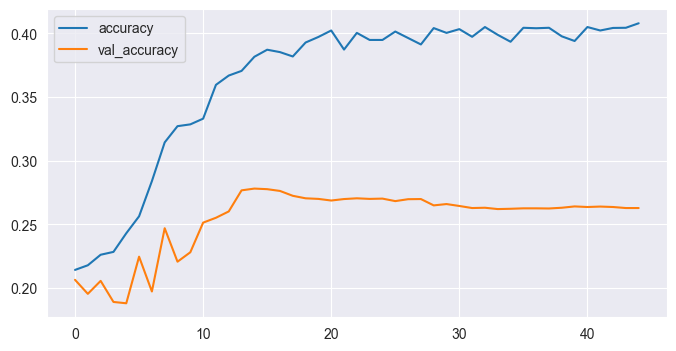

Start Training (total epochs: 100)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 35.69%
Maximum validation accuracy : 28.83%


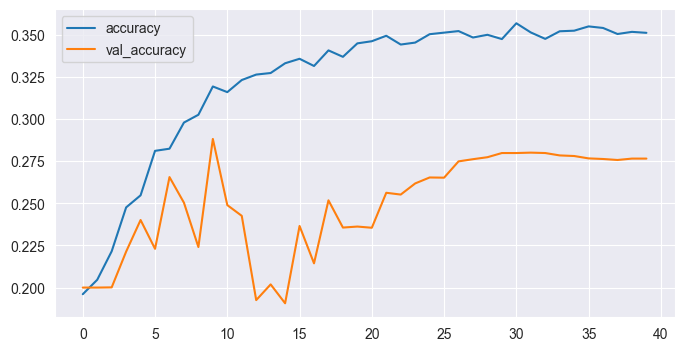

In [13]:
SUBJECT = 'Byeongchan'
X_emg1, y_emg1, X_emg2, y_emg2 = get_data(subject=SUBJECT, modality='EMG')
X_eng1, y_eng1, X_eng2, y_eng2 = get_data(subject=SUBJECT, modality='ENG')

X1 = np.concatenate([X_emg1, X_eng1], axis=0)
X2 = np.concatenate([X_emg2, X_eng2], axis=0)
y1 = np.concatenate([y_emg1, y_eng1], axis=0)
y2 = np.concatenate([y_emg2, y_eng2], axis=0)

train_model(X1, y1, X2, y2, heatmap_bool=False)
train_model(X2, y2, X1, y1, heatmap_bool=False)

# Hongjun

Start Training (total epochs: 100)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 74.82%
Maximum validation accuracy : 36.32%


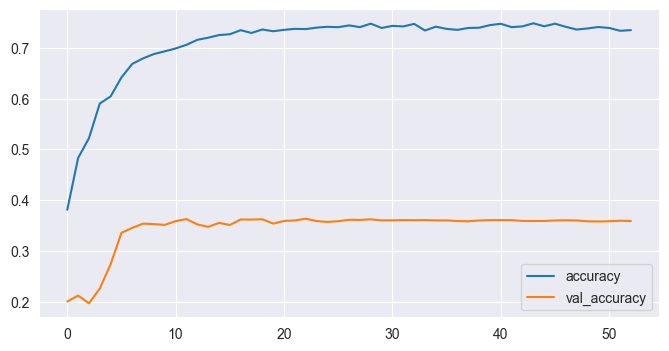

Start Training (total epochs: 100)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 60.32%
Maximum validation accuracy : 41.37%


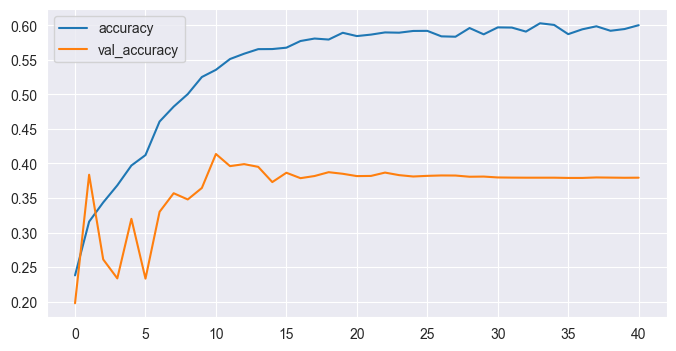

In [14]:
SUBJECT = 'Hongjun'
X_emg1, y_emg1, X_emg2, y_emg2 = get_data(subject=SUBJECT, modality='EMG')
X_eng1, y_eng1, X_eng2, y_eng2 = get_data(subject=SUBJECT, modality='ENG')

X1 = np.concatenate([X_emg1, X_eng1], axis=0)
X2 = np.concatenate([X_emg2, X_eng2], axis=0)
y1 = np.concatenate([y_emg1, y_eng1], axis=0)
y2 = np.concatenate([y_emg2, y_eng2], axis=0)

train_model(X1, y1, X2, y2, heatmap_bool=False)
train_model(X2, y2, X1, y1, heatmap_bool=False)

# Jongin

Start Training (total epochs: 100)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 42.5%
Maximum validation accuracy : 38.55%


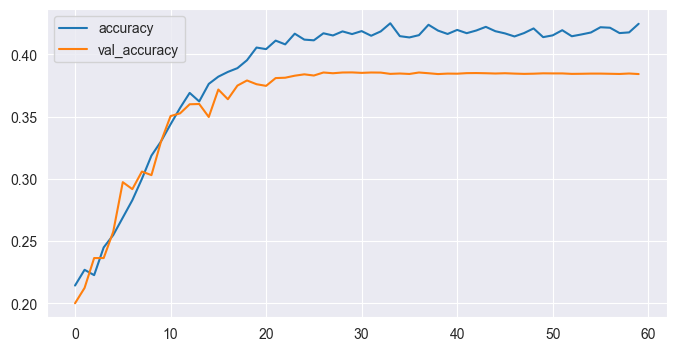

Start Training (total epochs: 100)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 33.09%
Maximum validation accuracy : 28.46%


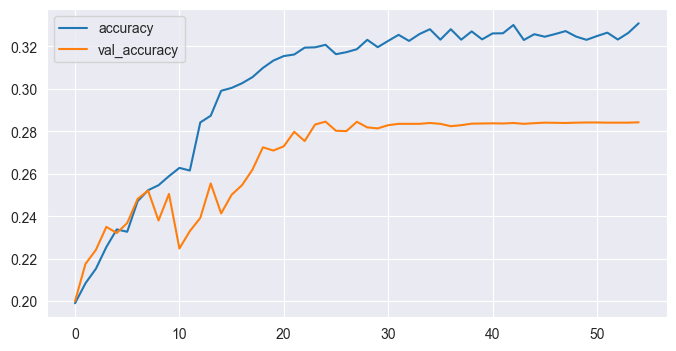

In [15]:
SUBJECT = 'Jongin'
X_emg1, y_emg1, X_emg2, y_emg2 = get_data(subject=SUBJECT, modality='EMG')
X_eng1, y_eng1, X_eng2, y_eng2 = get_data(subject=SUBJECT, modality='ENG')

X1 = np.concatenate([X_emg1, X_eng1], axis=0)
X2 = np.concatenate([X_emg2, X_eng2], axis=0)
y1 = np.concatenate([y_emg1, y_eng1], axis=0)
y2 = np.concatenate([y_emg2, y_eng2], axis=0)

train_model(X1, y1, X2, y2, heatmap_bool=False)
train_model(X2, y2, X1, y1, heatmap_bool=False)

# Youngchul

Start Training (total epochs: 100)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 24.76%
Maximum validation accuracy : 13.76%


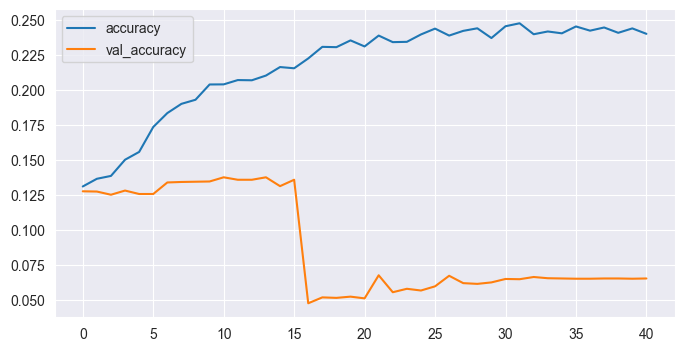

Start Training (total epochs: 100)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 12.62%
Maximum validation accuracy : 12.67%


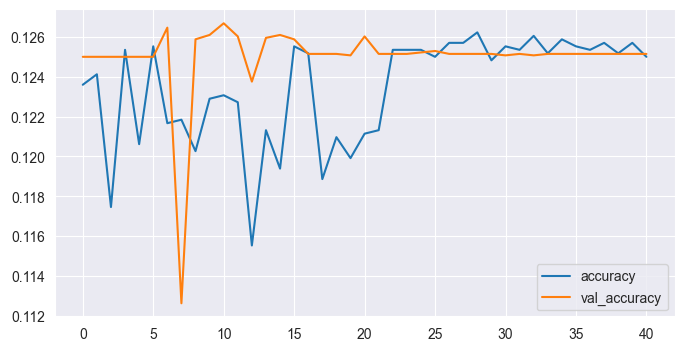

In [16]:
SUBJECT = 'Youngchul'
X_emg1, y_emg1, X_emg2, y_emg2 = get_data(subject=SUBJECT, modality='EMG')
X_eng1, y_eng1, X_eng2, y_eng2 = get_data(subject=SUBJECT, modality='ENG')

X1 = np.concatenate([X_emg1, X_eng1], axis=0)
X2 = np.concatenate([X_emg2, X_eng2], axis=0)
y1 = np.concatenate([y_emg1, y_eng1], axis=0)
y2 = np.concatenate([y_emg2, y_eng2], axis=0)

train_model(X1, y1, X2, y2, heatmap_bool=False)
train_model(X2, y2, X1, y1, heatmap_bool=False)

# Harold

Start Training (total epochs: 100)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 37.48%
Maximum validation accuracy : 29.92%


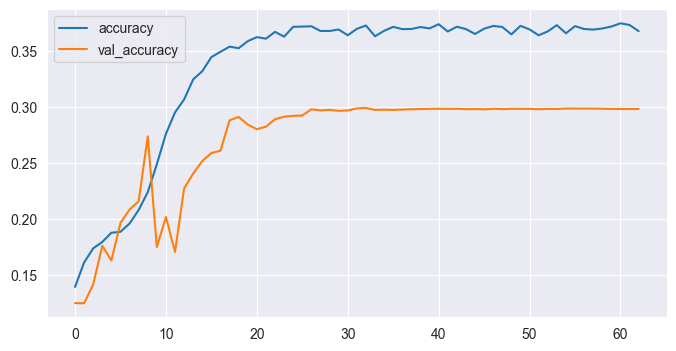

Start Training (total epochs: 100)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 58.31%
Maximum validation accuracy : 31.87%


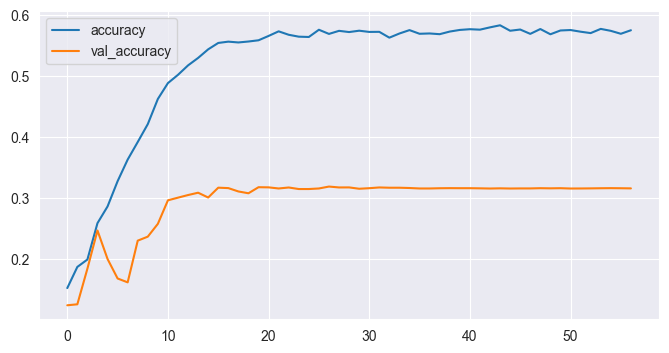

In [17]:
SUBJECT = 'Harold'
X_emg1, y_emg1, X_emg2, y_emg2 = get_data(subject=SUBJECT, modality='EMG')
X_eng1, y_eng1, X_eng2, y_eng2 = get_data(subject=SUBJECT, modality='ENG')

X1 = np.concatenate([X_emg1, X_eng1], axis=0)
X2 = np.concatenate([X_emg2, X_eng2], axis=0)
y1 = np.concatenate([y_emg1, y_eng1], axis=0)
y2 = np.concatenate([y_emg2, y_eng2], axis=0)

train_model(X1, y1, X2, y2, heatmap_bool=False)
train_model(X2, y2, X1, y1, heatmap_bool=False)

# Carlson

Start Training (total epochs: 100)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 48.75%
Maximum validation accuracy : 29.35%


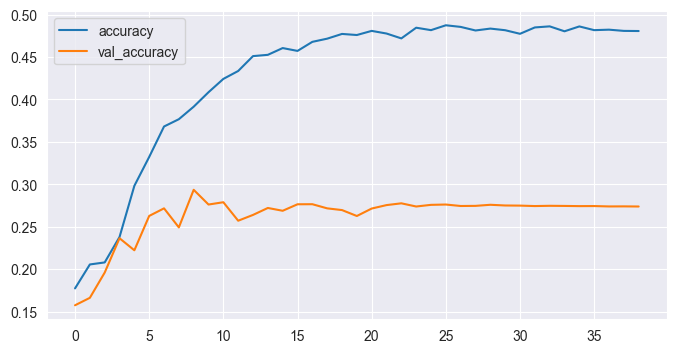

Start Training (total epochs: 100)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 44.0%
Maximum validation accuracy : 29.16%


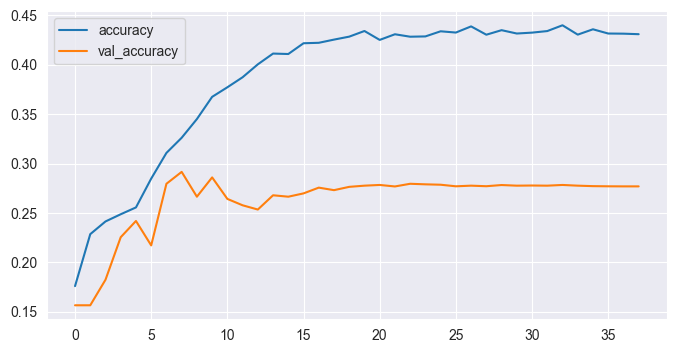

In [18]:
SUBJECT = 'Carlson'
X_emg1, y_emg1, X_emg2, y_emg2 = get_data(subject=SUBJECT, modality='EMG')
X_eng1, y_eng1, X_eng2, y_eng2 = get_data(subject=SUBJECT, modality='ENG')

X1 = np.concatenate([X_emg1, X_eng1], axis=0)
X2 = np.concatenate([X_emg2, X_eng2], axis=0)
y1 = np.concatenate([y_emg1, y_eng1], axis=0)
y2 = np.concatenate([y_emg2, y_eng2], axis=0)

train_model(X1, y1, X2, y2, heatmap_bool=False)
train_model(X2, y2, X1, y1, heatmap_bool=False)

# Minjeong

Start Training (total epochs: 100)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 21.8%
Maximum validation accuracy : 17.58%


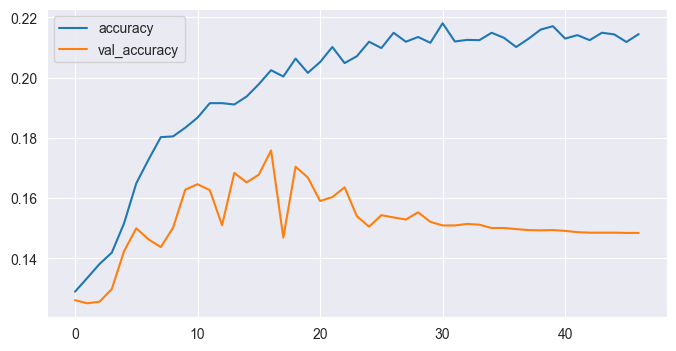

Start Training (total epochs: 100)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 20.93%
Maximum validation accuracy : 18.25%


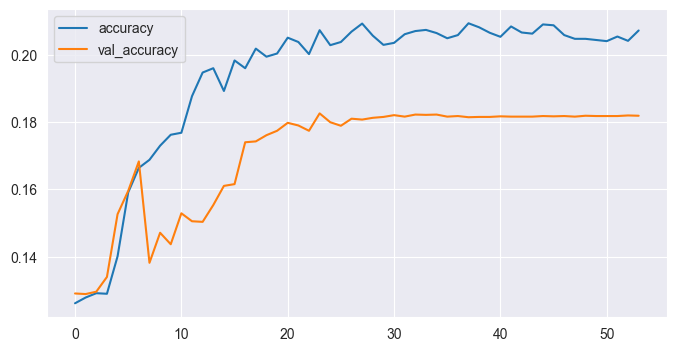

In [19]:
SUBJECT = 'Minjeong'
X_emg1, y_emg1, X_emg2, y_emg2 = get_data(subject=SUBJECT, modality='EMG')
X_eng1, y_eng1, X_eng2, y_eng2 = get_data(subject=SUBJECT, modality='ENG')

X1 = np.concatenate([X_emg1, X_eng1], axis=0)
X2 = np.concatenate([X_emg2, X_eng2], axis=0)
y1 = np.concatenate([y_emg1, y_eng1], axis=0)
y2 = np.concatenate([y_emg2, y_eng2], axis=0)

train_model(X1, y1, X2, y2, heatmap_bool=False)
train_model(X2, y2, X1, y1, heatmap_bool=False)

# Xianyu

Start Training (total epochs: 100)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 39.86%
Maximum validation accuracy : 25.61%


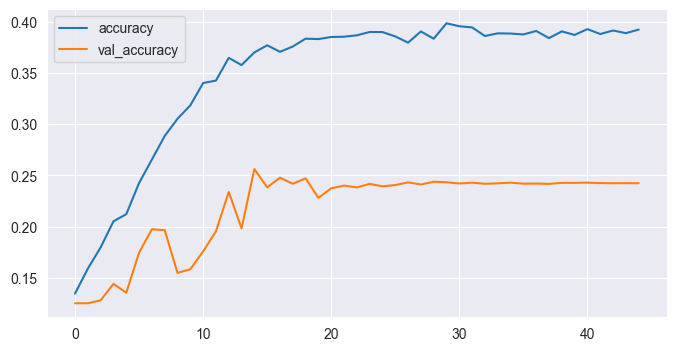

Start Training (total epochs: 100)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 38.81%
Maximum validation accuracy : 24.74%


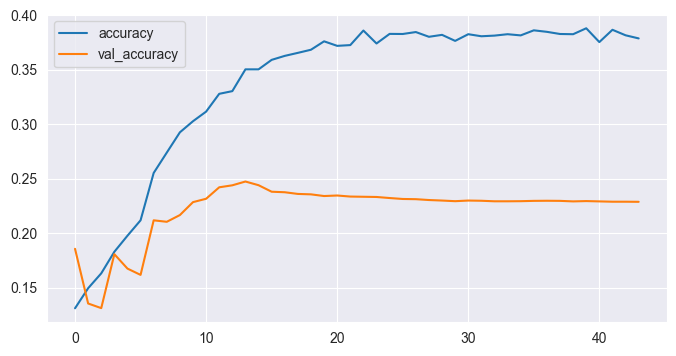

In [20]:
SUBJECT = 'Xianyu'
X_emg1, y_emg1, X_emg2, y_emg2 = get_data(subject=SUBJECT, modality='EMG')
X_eng1, y_eng1, X_eng2, y_eng2 = get_data(subject=SUBJECT, modality='ENG')

X1 = np.concatenate([X_emg1, X_eng1], axis=0)
X2 = np.concatenate([X_emg2, X_eng2], axis=0)
y1 = np.concatenate([y_emg1, y_eng1], axis=0)
y2 = np.concatenate([y_emg2, y_eng2], axis=0)

train_model(X1, y1, X2, y2, heatmap_bool=False)
train_model(X2, y2, X1, y1, heatmap_bool=False)